# Whisper Benchmark – Large Models

## Set up env (outside notebook)

Run on terminal:

```
docker run -d -p 6379:6379 redis
celery -A tasks worker -P solo --loglevel=INFO
```

## Run tests

### Set up

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

from tasks import transcribe

audio_filename = 'stephen_fry.wav'

model_names = ['medium.en', 'large']

### Full transcription

In [4]:
n_runs = 3

for _ in range(n_runs):
    for model_name in model_names:
        transcribe.delay(audio_filename, model_name)

#### Results

In [11]:
full_results = {name: pd.read_csv(f'performance_{name}.csv', header=None)[0] for name in model_names}
df_full = pd.DataFrame.from_dict(full_results, orient='columns')

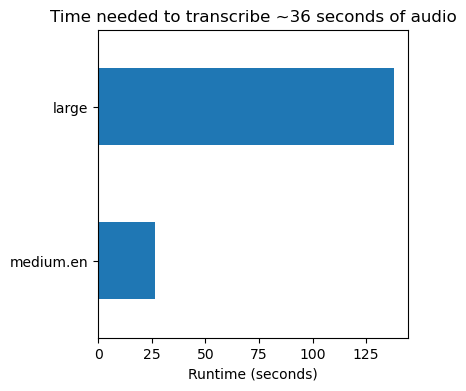

In [13]:
df_full.mean().plot.barh(figsize=(4,4))
plt.xlabel('Runtime (seconds)')
plt.title('Time needed to transcribe ~36 seconds of audio');

### Snippets

In [5]:
import audio2numpy as a2n
import numpy as np
import os
from uuid import uuid1
from scipy.io import wavfile

In [6]:
np_audio, sampling_rate = a2n.audio_from_file(audio_filename)

def split_audio(np_audio, chunk_seconds, sampling_rate=96000):
    indices = np.arange(sampling_rate*chunk_seconds, len(np_audio), sampling_rate*chunk_seconds)
    return np.split(np_audio, indices)

chunk_sizes = [2, 3, 5, 7]
snippets = {size: split_audio(np_audio, size, sampling_rate) for size in chunk_sizes}

In [7]:
temp_dir = 'tempfiles'
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

n_runs=3
for _ in range(n_runs):
    for size, snips in snippets.items():
        for model_name in model_names:
            for i, snip in enumerate(snips):
                temp_filename = str(uuid1())
                write_path = os.path.join(temp_dir, temp_filename) + '.wav'
                wavfile.write(write_path, sampling_rate, snip)
                transcribe.delay(write_path, model_name, chunk_size=size, counter=i)

#### Performance

In [14]:
snip_runtimes = {}
for model_name in model_names:
    snip_runtimes[model_name] = {}
    for size in chunk_sizes:
        snip_runtimes[model_name].update({
            size: pd.read_csv(f'performance_{model_name}_{size}secs.csv', header=None)[0]
        })

snip_results = {model_name: pd.DataFrame.from_dict(snip_runtimes[model_name], orient='columns') for model_name in model_names}

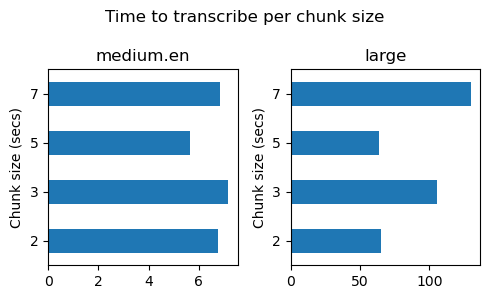

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(5,3))
for i, model_name in enumerate(model_names):
    snip_results[model_name].mean().plot.barh(ax=ax[i])
    ax[i].set_title(model_name)
    ax[i].set_ylabel('Chunk size (secs)')
fig.suptitle('Time to transcribe per chunk size');
plt.tight_layout()

### Transcripts

In [16]:
for model_name in model_names:
    for size in chunk_sizes:
        transcript = []
        for i in range(18):
            filename = f'transcription_{model_name}_{size}secs_{i}.txt'
            if os.path.exists(filename):
                with open(filename, 'r') as f:
                    transcript.append(f.readlines()[0])
        out_file = f'transcription_{model_name}_{size}secs.txt'
        with open(out_file, 'w') as f:
            f.write(''.join(transcript))

#### Compute similarity to baseline

Text pre-processing: Replace newlines with spaces.

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

from sklearn.metrics.pairwise import cosine_similarity

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


In [18]:
similarity_results = {}
for model_name in model_names:
    similarity_results[model_name] = {}

    with open(f'transcription_{model_name}.txt', 'r') as f:
        baseline = f.read()

    chunks = {}
    for file in os.listdir():
        if f'transcription_{model_name}' in file and 'secs.txt' in file:
            chunk_size = file[file.find('secs.txt')-1]
            with open(file, 'r') as f:
                chunks[chunk_size] = f.read().replace('\n', ' ')

    baseline_encoded = model.encode(baseline, show_progress_bar=False)

    chunks_encoded = {size: model.encode(text) for size, text in chunks.items()}

    for size, encoded_chunk in chunks_encoded.items():
        similarity = cosine_similarity(baseline_encoded.reshape(1, -1), encoded_chunk.reshape(1, -1))
        similarity_results[model_name][int(size)] = similarity[0][0]

# print results
for model_name in model_names:
    print(f'==== MODEL {model_name} ===='.upper())
    for size in chunk_sizes:
        print(f'Simlarity between baseline and snippet with {size} seconds: {round(similarity_results[model_name][size], 2)}')

Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.28it/s]

==== MODEL MEDIUM.EN ====
Simlarity between baseline and snippet with 2 seconds: 0.9100000262260437
Simlarity between baseline and snippet with 3 seconds: 0.9800000190734863
Simlarity between baseline and snippet with 5 seconds: 0.9599999785423279
Simlarity between baseline and snippet with 7 seconds: 0.9800000190734863
==== MODEL LARGE ====
Simlarity between baseline and snippet with 2 seconds: 0.9700000286102295
Simlarity between baseline and snippet with 3 seconds: 0.9300000071525574
Simlarity between baseline and snippet with 5 seconds: 0.9800000190734863
Simlarity between baseline and snippet with 7 seconds: 0.9700000286102295


In [19]:
for i, (model_name, simil_results) in enumerate(similarity_results.items()):
    print(f'Mean similarity for {model_name}: {pd.DataFrame.from_dict({model_name: simil_results}).mean().values[0]:.2f}')

Mean similarity for medium.en: 0.96
Mean similarity for large: 0.96


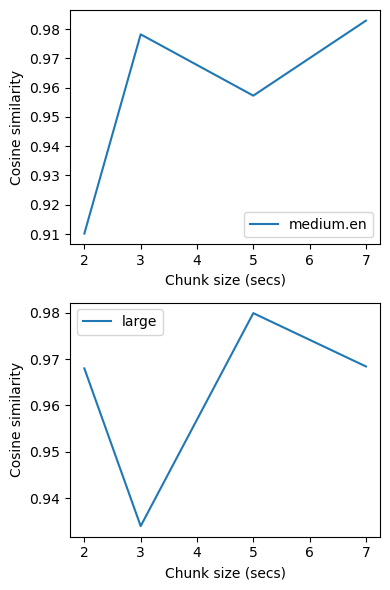

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(4,6))
for i, (model_name, simil_results) in enumerate(similarity_results.items()):
    pd.DataFrame.from_dict({model_name: simil_results}).plot.line(ax=ax[i])
    ax[i].set_ylabel('Cosine similarity')
    ax[i].set_xlabel('Chunk size (secs)')
plt.tight_layout()